In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
import keras
import tensorflow
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as prf


Using TensorFlow backend.


In [2]:
print('keras:', keras.__version__)
print('tensorflow:',tensorflow.__version__)
!python3 --version

keras: 2.2.4
tensorflow: 1.13.1
Python 3.6.6 :: Anaconda, Inc.


In [3]:
import warnings 
warnings.filterwarnings("ignore")

In [4]:
DATA_DIR = '/kaggle/input'

# Directory to save logs and trained model
ROOT_DIR = '/kaggle/working'

In [5]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
#!python setup.py -q install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 137.67 MiB | 43.45 MiB/s, done.
Resolving deltas: 100% (558/558), done.


In [6]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [7]:
train_dicom_dir = os.path.join(DATA_DIR, 'rsna-pneumonia-detection-challenge/stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'rsna-pneumonia-detection-challenge/stage_2_test_images')

In [8]:
### Download COCO pre-trained weights
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "/kaggle/input/mask-rcnn-coco/mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Dec  6  2021 mask_rcnn_coco.h5


In [9]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns):
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [10]:
hyper_paramters_comb={
    'backbone':['resnet50'],
    'learning_rate':[0.005],
    'batch_size':[8],
    'epochs':[10],
    'det_min_conf':[0.9],
    'det_nms_th':[0.8],
    'rpn_nms_th':[0.7],
    'steps_per_epoch':[135],
    'layers': ['heads']
}

hpc=pd.DataFrame(hyper_paramters_comb)

hpc['learning_rate'] = hpc['learning_rate'].astype(np.float32)
hpc['det_min_conf'] = hpc['det_min_conf'].astype(np.float32)
hpc['det_nms_th'] = hpc['det_nms_th'].astype(np.float32)
hpc['rpn_nms_th'] = hpc['rpn_nms_th'].astype(np.float32)

hpc.head()

,backbone,learning_rate,batch_size,epochs,det_min_conf,det_nms_th,rpn_nms_th,steps_per_epoch,layers
0,resnet50,0.005,8,10,0.9,0.8,0.7,135,heads


In [11]:
# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'))
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [12]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [13]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [14]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

**Split the data into training and validation datasets that exctly macthes the dataset used for other models in the project**

In [15]:
def dataset_model(image_names):
    org_train, org_val = train_test_split(anns, test_size=0.30, random_state=32)
    
    #  taking subset of train and validation dataset
    org_train_1=org_train[org_train.Target==1]
    org_train_0=org_train[org_train.Target==0]
    image_fps_train=org_train_1.patientId[:1500].tolist() + org_train_0.patientId[:500].tolist()
    image_fps_train=[train_dicom_dir+'/'+x+'.dcm' for x in image_fps_train]

    org_val_1=org_val[org_val.Target==1]
    org_val_0=org_val[org_val.Target==0]
    image_fps_val=org_val_1.patientId[:350].tolist() + org_val_0.patientId[:150].tolist()
    image_fps_val=[train_dicom_dir+'/'+x+'.dcm' for x in image_fps_val]
    
    image_fps_test=org_val_1.patientId[1500:1800].tolist() + org_val_0.patientId[500:700].tolist()
    image_fps_test=[train_dicom_dir+'/'+x+'.dcm' for x in image_fps_test]
    print(len(image_fps_train), len(image_fps_val), len(image_fps_test))

    return image_fps_train, image_fps_val, image_fps_test


In [16]:
image_fps_train, image_fps_val, image_fps_test=dataset_model(image_fps)

2000 500 500


In [17]:
len(image_fps_train), len(image_fps_val), len(image_fps_test)

(2000, 500, 500)

In [18]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [19]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [20]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

**Display a random image with bounding boxes**

(1024, 1024, 3)
/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/0428e86e-a279-4bdf-9b73-c9eead06a4e7.dcm
[1 1]


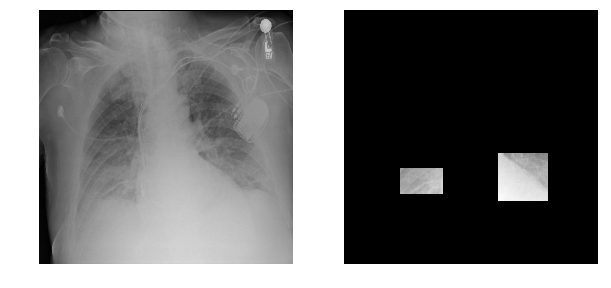

In [21]:
# Load and display a random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')


print(image_fp)
print(class_ids)

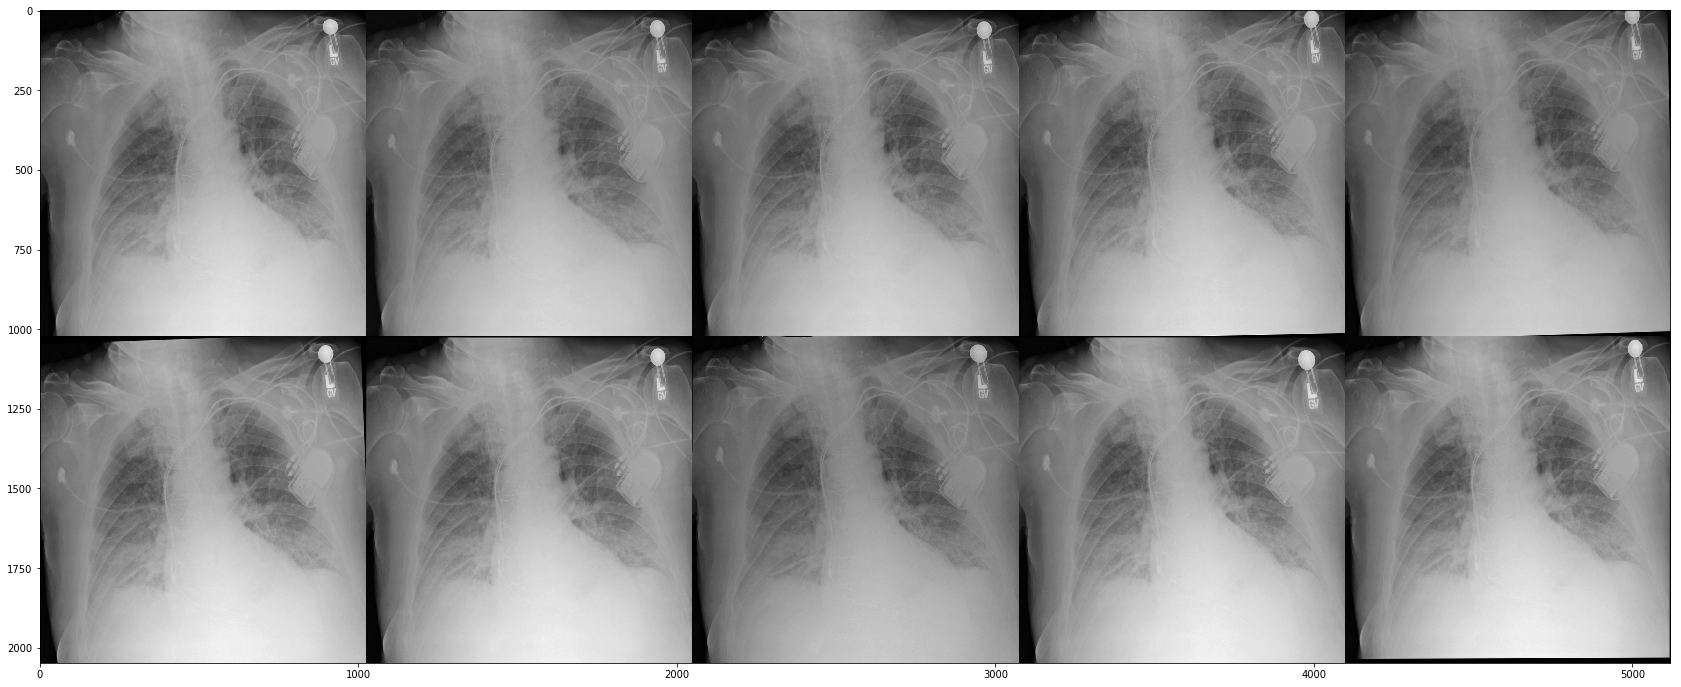

In [22]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

In [23]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = hpc.iloc[0]['backbone']
    BATCH_SIZE=hpc.iloc[0]['batch_size']
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = hpc.iloc[0]['det_min_conf']
    DETECTION_NMS_THRESHOLD = hpc.iloc[0]['det_nms_th']
    RPN_NMS_THRESHOLD = hpc.iloc[0]['rpn_nms_th']
    STEPS_PER_EPOCH = hpc.iloc[0]['steps_per_epoch']


In [24]:
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.8999999761581421
DETECTION_NMS_THRESHOLD        0.800000011920929
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 

In [25]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Exclude the last layers because they require a matching number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

Instructions for updating:
Colocations handled automatically by placer.


In [26]:
%%time
checkpoint_path = os.path.join(ROOT_DIR, "mask_rcnn_{}_*epoch*.h5".format(config.NAME.lower()))
checkpoint_path = checkpoint_path.replace("*epoch*", "{epoch:04d}")
callbacks = [keras.callbacks.ModelCheckpoint(checkpoint_path,verbose=1, save_weights_only=True,period=1)]

model.train(dataset_train, dataset_val, 
            learning_rate=hpc.iloc[0]['learning_rate'], 
            epochs=hpc.iloc[0]['epochs'], 
            custom_callbacks=callbacks,
            layers=hpc.iloc[0]['layers'],
            augmentation=augmentation)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.004999999888241291

Checkpoint Path: /kaggle/working/pneumonia20230501T0207/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)


In [27]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,1.750786,0.052684,0.529537,0.314283,0.464585,0.389694,1.842707,0.057842,0.446477,0.336985,0.564745,0.436655
2,1.565942,0.052476,0.456266,0.262899,0.425288,0.369011,1.681818,0.044682,0.456189,0.304517,0.475448,0.400981
3,1.643878,0.041502,0.549823,0.238222,0.428632,0.385698,1.582144,0.044607,0.432236,0.288205,0.431448,0.385646
4,1.694084,0.052042,0.587047,0.254084,0.430740,0.370168,1.613005,0.047518,0.462400,0.298628,0.422493,0.381964
5,1.511052,0.047500,0.466038,0.216220,0.413393,0.367898,1.538535,0.046784,0.423820,0.272680,0.418760,0.376489
6,1.735812,0.057398,0.517811,0.349257,0.432697,0.378646,1.551747,0.044217,0.448227,0.277316,0.403743,0.378241
7,1.587900,0.046110,0.469883,0.262061,0.432579,0.377263,1.560099,0.047345,0.465036,0.271726,0.404096,0.371892
8,1.656405,0.052071,0.547761,0.273012,0.409027,0.374529,1.481475,0.040758,0.409704,0.277540,0.387128,0.366340
9,1.505254,0.050841,0.430055,0.260277,0.409580,0.354495,1.460842,0.040829,0.419386,0.249162,0.381425,0.370034
10,1.656261,0.048769,0.580946,0.255792,0.392095,0.378651,1.483358,0.040546,0.393480,0.288627,0.389845,0.370854


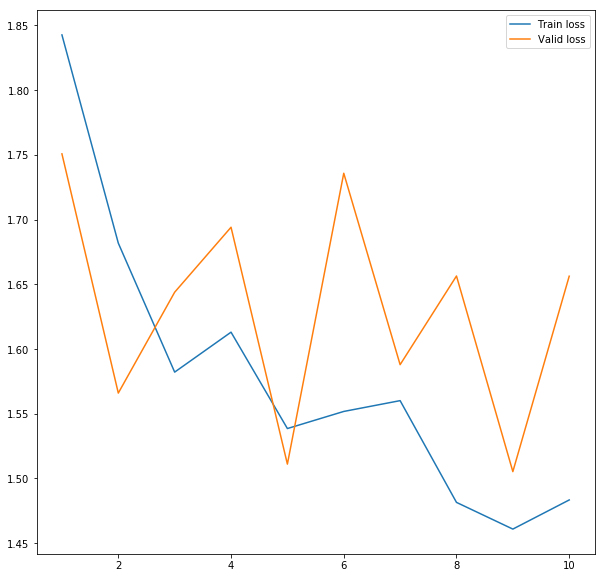

In [28]:
plt.figure(figsize=(10,10))
plt.subplot(111)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.show()

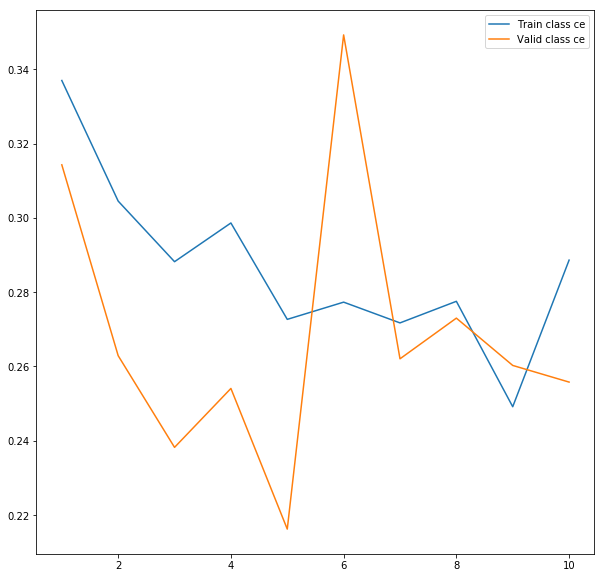

In [29]:
plt.figure(figsize=(10,10))
plt.subplot(111)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.show()

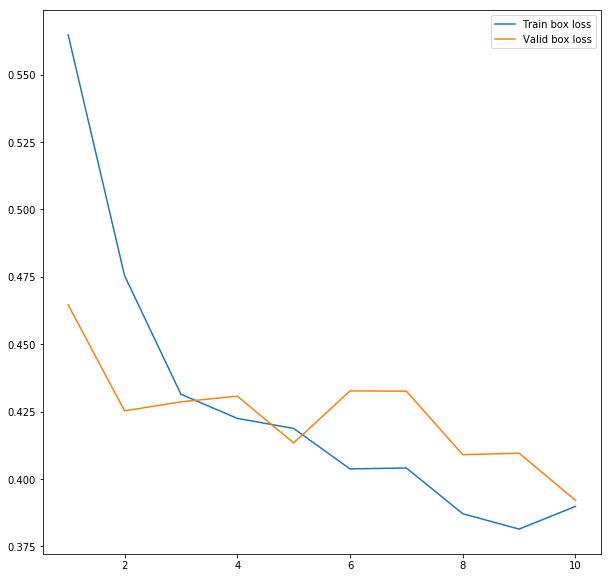

In [30]:
plt.figure(figsize=(10,10))
plt.subplot(111)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()
plt.show()

In [31]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 9 1.5052538514137268


In [32]:
x=filter(lambda f : (f.startswith('mask_rcnn_pneumonia') and ((4-len(str(best_epoch+1)))*str(0)+str(best_epoch+1)) in f), os.listdir(model.model_dir))
model_path=model.model_dir+'/'+list(x)[0]
print('Found model at {}'.format(model_path))

Found model at /kaggle/working/mask_rcnn_pneumonia_0009.h5


In [33]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', config=inference_config, model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /kaggle/working/mask_rcnn_pneumonia_0009.h5


In [34]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

**How does the predicted box compared to the expected value? Let's use the validation dataset to check.**

In [35]:
# prepare the validation dataset
dataset_test = DetectorDataset(image_fps_test, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_test.prepare()

In [36]:
images=dataset_test.image_ids

ytrue=[]
ypred=[]

for i in range(len(images)):
        original_image,_, _, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_test, inference_config, images[i], use_mini_mask=False)
        ytrue.append(gt_bbox)
        results=model.detect([original_image])
        ypred.append(results[0]['rois'])

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


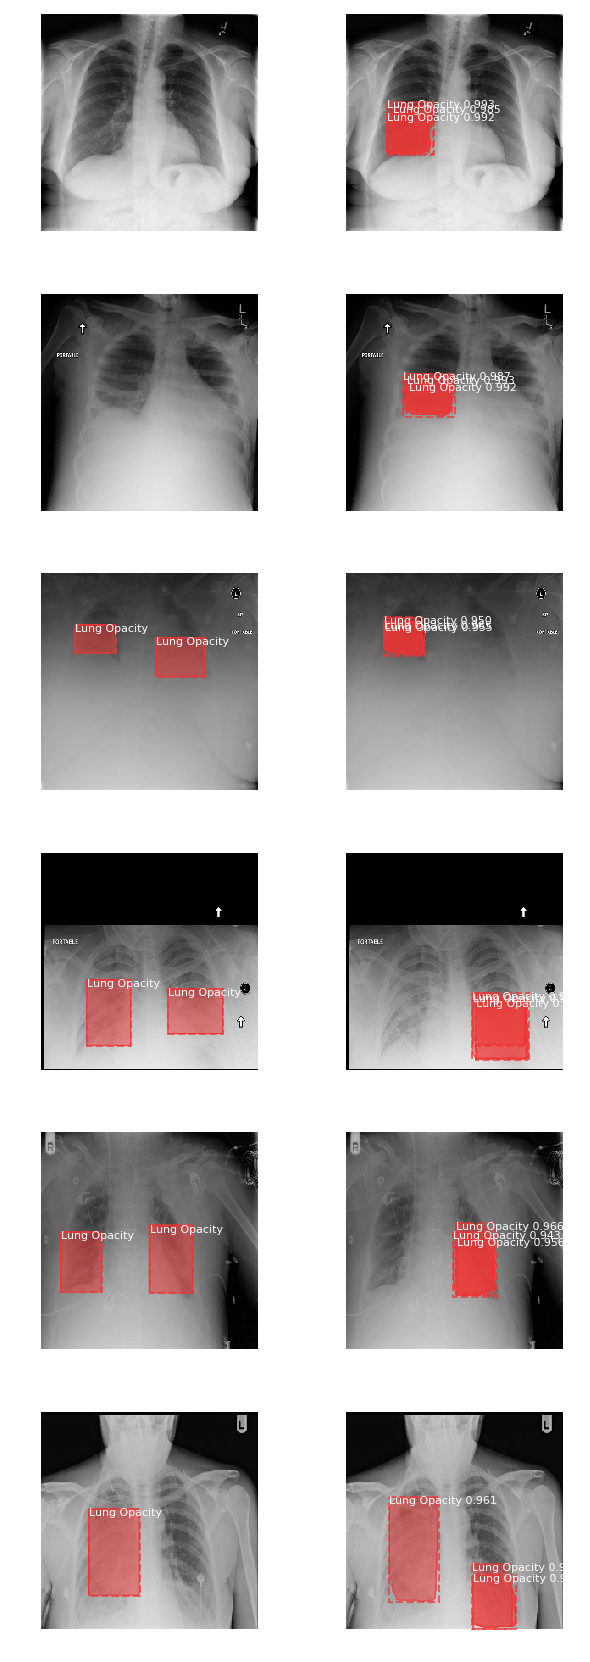

In [37]:
# Show few example of ground truth vs. predictions on the test dataset 
dataset = dataset_test
fig = plt.figure(figsize=(10, 30))
img_array=[]
for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    img_array.append(original_image)
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])


In [38]:
def loadmasks(bboxes):
    mask = np.zeros((bboxes.shape[0], ORIG_SIZE, ORIG_SIZE))
    for i in range(bboxes.shape[0]):
        if bboxes[i]==[]:
            continue
        else:
            for bbox in bboxes[i]:
                x, y, w, h = bbox
                x1=math.floor(x)
                y1=math.floor(y)
                x2=math.ceil(x+w)
                y2=math.ceil(y+h)
                mask[i, y1:y2,x1:x2] = 1

    return mask

In [39]:
def npmean_iou(bbox1, bbox2):
    mask1=loadmasks(np.array(bbox1))
    mask2=loadmasks(np.array(bbox2))
    union=np.count_nonzero(mask1, 1).astype(np.float32) + np.count_nonzero(mask2, 1).astype(np.float32)
    intersection = np.count_nonzero(np.logical_and(mask1, mask2), 1).astype(np.float32)
    smooth = np.ones(intersection.shape)
    iou = np.mean((intersection+smooth)/(union-intersection+smooth))
    return iou

iou=npmean_iou(ytrue, ypred)
iou

0.8602487806535155

In [40]:
prec, rec, f1s, _ = prf([1 if np.sum(x)>1 else 0 for x in ytrue], [1 if np.sum(x)>1 else 0 for x in ypred], average='binary')
prec, rec, f1s

(0.6028513238289206, 0.9866666666666667, 0.7484197218710493)

In [41]:
hpc.head()

,backbone,learning_rate,batch_size,epochs,det_min_conf,det_nms_th,rpn_nms_th,steps_per_epoch,layers
0,resnet50,0.005,8,10,0.9,0.8,0.7,135,heads
